# Statistical method for flow spell analysis

Alluvium Consulting 2024

For any enquary about the codes and methe refre to Jabbar Khaledi, Alex Sims, Kristen Joyse

# What is this notebook?
This notebook is a collection of code to read, clean, and visualize the flow data. It also includes statistical sullaries to compare catchments, and comparing statistics before and after a prefered time point. The codes preform spell analysis to calculate the frequency of days that baseflow, overbank flow, fresh flow, bank full is grater than threshold.

# How to use this notebook?
The code can be run on your pesonal computer if you already have Anaconda and Jupyter notbook installed.
If you are running the code on Colab, dont forget to run the last block of code (at the end of the notebook) to downlaod your outputs into your local computer.
The notebook provide input function for you, so you dont need to make any change in the code, just answer the questions that notebook asks you!.
The notebook has to be executed in order (i.e., from top to bottom) because some cells depend on the previous cells.

In [1]:
import importlib
import subprocess
import sys
import os
import sys
import glob
import math
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats as stats
from IPython.display import display
import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', str)
warnings.simplefilter('ignore')
os.environ['PROJ_LIB'] = r'C:\Users\jkhaledi\anaconda3\pkgs\proj4-5.2.0-h6538335_1004\Library\share'

### Define if you want to use the code on colab or your local system 
### Create a folder to save all your outputs (data, tables, and figures)
### and import your data

In [2]:
def create_output_folder():
    while True:
        # Input for directory path on local system
        dir_path = input("Enter the directory path where you want to create a folder to save outputs: ").strip()
        if not dir_path:
            print("Please provide a valid directory path.")
            continue
        dir_path = os.path.expanduser(dir_path)  # Expand user path if using ~
        
        # Check if the directory path is valid
        if not os.path.exists(dir_path):
            print(f"Directory path '{dir_path}' does not exist. Please provide a valid directory path.")
            continue
        # Input for folder name
        folder_name = 'Flow Metric Outputs'
        full_path = os.path.join(dir_path, folder_name)
        try:
            if not os.path.exists(full_path):
                os.makedirs(full_path)

        except OSError as e:
            print(f"Error creating folder '{folder_name}' at '{full_path}': {e}")
        else:
            break  # Exit the loop if folder creation was successful
    return full_path
def read_csv_with_pandas(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print("File not found. Please check the directory and try again.")
        return None
def import_data():
    # Ask for directory in local Jupyter Notebook
    print('=======================================================================================')
    print(' ')
    directory = input(r"Enter the path of the CSV file. For example, C:\Users\jabbar.khaledi\OneDrive - Alluvium Consulting Australia\Documents\Projects\R and I Alex\Input\Streamflow_Gauge_Outputs.csv: ").strip()
    try:
        return read_csv_with_pandas(directory)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None
# Example usage
output_folder = create_output_folder()
if output_folder:
    print(f"Output folder path: {output_folder}")

# Example usage
Flow_data = import_data()
if Flow_data is not None:
    print("Data imported successfully!")
Flow_data

Enter the directory path where you want to create a folder to save outputs:  C:\Users\jabbar.khaledi\OneDrive - Alluvium Consulting Australia\Documents\Projects\R and I Alex


Output folder path: C:\Users\jabbar.khaledi\OneDrive - Alluvium Consulting Australia\Documents\Projects\R and I Alex\Flow Metric Outputs
 


Enter the path of the CSV file. For example, C:\Users\jabbar.khaledi\OneDrive - Alluvium Consulting Australia\Documents\Projects\R and I Alex\Input\Streamflow_Gauge_Outputs.csv:  C:\Users\jabbar.khaledi\OneDrive - Alluvium Consulting Australia\Documents\Projects\R and I Alex\Input\Streamflow_Gauge_Outputs.csv


Data imported successfully!


,Date,Latest Run>Gauge>La Latrobe R @ Kilmany South>Downstream Flow (ML/d),Latest Run>Gauge>La Latrobe R @ Rosedale>Downstream Flow (ML/d),Latest Run>Gauge>La Latrobe R @ Scarnes Bridge>Downstream Flow (ML/d),Latest Run>Gauge>La Latrobe R @ Swing Bridge>Downstream Flow (ML/d),Latest Run>Gauge>La Latrobe R @ Thoms Bridge>Downstream Flow (ML/d),Latest Run>Gauge>La Latrobe R @ Willow Grove>Downstream Flow (ML/d),Latest Run>Gauge>La Little Morwell R @ Boolara>Downstream Flow (ML/d),Latest Run>Gauge>La Morwell R @ Yallourn>Downstream Flow (ML/d),Latest Run>Gauge>La Narracan Ck @ Moe>Downstream Flow (ML/d),Latest Run>Gauge>La Narracan Ck @ Thorpdale>Downstream Flow (ML/d),Latest Run>Gauge>La Traralgon Ck @ Traralgon>Downstream Flow (ML/d),Latest Run>Gauge>La Tyers @ Pump House>Downstream Flow (ML/d),Latest Run>Gauge>La Tyers R @ Browns>Downstream Flow (ML/d)
0,1/01/1957,635.1550158,756.1356174,1042.634244,911.8873106,1276.568077,611.268554,1.5e-16,407.5997271,69.70159293,64.76165706,13.68925394,8.0,0.0
1,2/01/1957,958.9762546,1103.561699,1324.014684,1197.450981,1385.790769,588.7328709,0.0,296.0789612,64.61759431,61.4815085,13.68925394,8.0,0.0
2,3/01/1957,1074.351444,1175.58912,1262.47826,1277.140933,1215.913802,572.9765977,0.0,267.2229875,37.64734049,33.82829044,13.68925394,8.0,0.0
3,4/01/1957,1112.067561,1158.641431,1177.647757,1331.468181,1141.128891,565.84309,0.0,237.8910984,36.89824007,33.31967476,13.68925394,8.0,0.0
4,5/01/1957,1084.328427,1104.873966,1117.373518,1361.048294,1089.336565,557.5094402,0.0,195.433813,36.2098739,32.39567128,13.68925394,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23187,26/06/2020,2968.13794,2869.1162,2357.031766,5223.72691,1828.614323,415.31,22.11,850.2037957,99.70429843,48.31429843,149.5392539,30.0,228.31
23188,27/06/2020,2483.967783,2330.464145,1888.4412,4904.070819,1535.281946,399.71,28.58,644.7275962,92.83429843,47.76429843,103.9092539,30.0,216.04
23189,28/06/2020,2050.626171,1903.241223,1589.157656,4153.664492,1329.085253,378.59,21.59,526.520933,90.82429843,47.13429843,80.84925394,30.0,200.47
23190,29/06/2020,1724.320929,1603.945519,1382.144672,3168.298684,1174.192815,363.28,21.17,444.6145017,88.52429843,46.89429843,68.03925394,30.0,184.4


## Select gauge/s (river) you wonat and clean the data

This cell also creates one subfolder for each gauge in the Flow Metric Outputs folder.

In [3]:
# Function to get user input for column selection
def select_columns(df):
    print("Columns in DataFrame:")
    for i, col in enumerate(df.columns):
        print(f"{i + 1}. {col}")   
    while True:
        choice = input("\nEnter column number(s) to select (comma-separated, e.g., '1, 3, 4'), or enter 'all' to select all columns: ")
        if choice.lower() == 'all':
            return df.columns.tolist()
        try:
            selected_indices = [int(idx.strip()) - 1 for idx in choice.split(',')]
            selected_columns = [df.columns[idx] for idx in selected_indices]
            return selected_columns
        except ValueError:
            print("Invalid input. Please enter comma-separated numbers corresponding to columns.")
        except IndexError:
            print("Invalid column number. Please select from the list above.")

# Main program flow
selected_columns = select_columns(Flow_data)

# Display data for selected columns
Flow_data = Flow_data[selected_columns]

# Function to strip leading and trailing spaces from DataFrame columns
def strip_column_names(df):
    df.columns = df.columns.str.strip()
    return df

Flow_data = strip_column_names(Flow_data)
print('=======================================================================================')
print('The date/Date column in your data should be Date with capital letter')

# Prepare new names based on user input
new_names = {}
for column in Flow_data.columns:
    new_name = input(f"Enter new name for column '{column}': ").strip()
    new_names[column] = new_name

# Rename columns in the DataFrame
Flow_data.rename(columns=new_names, inplace=True)
# Convert 'Date' column to datetime with correct format
Flow_data['Date'] = pd.to_datetime(Flow_data['Date'], format='%d/%m/%Y')
Flow_data = strip_column_names(Flow_data)
print('=======================================================================================')
# Create subfolders for each column (except 'Date') in 'Flow Metrics Output'
for column in Flow_data.columns:
    if column != 'Date':
        subfolder_path = os.path.join(output_folder, column)
        try:
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)
            print(f"Subfolder created for column: {column}")
        except OSError as e:
            print(f"Error creating subfolder '{column}': {e}")
print("\nSelected Data:")
Flow_data

Columns in DataFrame:
1. Date
2. Latest Run>Gauge>La Latrobe R @ Kilmany South>Downstream Flow (ML/d)
3. Latest Run>Gauge>La Latrobe R @ Rosedale>Downstream Flow (ML/d)
4. Latest Run>Gauge>La Latrobe R @ Scarnes Bridge>Downstream Flow (ML/d)
5. Latest Run>Gauge>La Latrobe R @ Swing Bridge>Downstream Flow (ML/d)
6. Latest Run>Gauge>La Latrobe R @ Thoms Bridge>Downstream Flow (ML/d)
7. Latest Run>Gauge>La Latrobe R @ Willow Grove>Downstream Flow (ML/d)
8. Latest Run>Gauge>La Little Morwell R @ Boolara>Downstream Flow (ML/d)
9. Latest Run>Gauge>La Morwell R @ Yallourn>Downstream Flow (ML/d)
10. Latest Run>Gauge>La Narracan Ck @ Moe>Downstream Flow (ML/d)
11. Latest Run>Gauge>La Narracan Ck @ Thorpdale>Downstream Flow (ML/d)
12. Latest Run>Gauge>La Traralgon Ck @ Traralgon>Downstream Flow (ML/d)
13. Latest Run>Gauge>La Tyers @ Pump House>Downstream Flow (ML/d)
14. Latest Run>Gauge>La Tyers R @ Browns>Downstream Flow (ML/d)



Enter column number(s) to select (comma-separated, e.g., '1, 3, 4'), or enter 'all' to select all columns:  1,2,3


The date/Date column in your data should be Date with capital letter


Enter new name for column 'Date':  Date
Enter new name for column 'Latest Run>Gauge>La Latrobe R @ Kilmany South>Downstream Flow (ML/d)':  Kilmany South
Enter new name for column 'Latest Run>Gauge>La Latrobe R @ Rosedale>Downstream Flow (ML/d)':  Rosedale


Subfolder created for column: Kilmany South
Subfolder created for column: Rosedale

Selected Data:


,Date,Kilmany South,Rosedale
0,1957-01-01,635.1550158,756.1356174
1,1957-01-02,958.9762546,1103.561699
2,1957-01-03,1074.351444,1175.58912
3,1957-01-04,1112.067561,1158.641431
4,1957-01-05,1084.328427,1104.873966
...,...,...,...
23187,2020-06-26,2968.13794,2869.1162
23188,2020-06-27,2483.967783,2330.464145
23189,2020-06-28,2050.626171,1903.241223
23190,2020-06-29,1724.320929,1603.945519


## Aggregate the daily data to monthly, annual, and water year

This code aggregates your data to higher level of monthly, annual, and water year

In [4]:
def check_date_frequency(data):
    data['Date'] = pd.to_datetime(data['Date'])
    date_diff = data['Date'].diff().dropna()
    
    # Calculate the most common difference
    most_common_diff = date_diff.mode()[0]
    
    if most_common_diff == pd.Timedelta(days=1):
        return "The data is daily."
    elif most_common_diff == pd.Timedelta(days=30) or most_common_diff == pd.Timedelta(days=31):
        return "The data is monthly."
    elif most_common_diff == pd.Timedelta(days=365) or most_common_diff == pd.Timedelta(days=366):
        return "The data is annual."
    else:
        return "The data frequency is not clearly daily, monthly, or annual."      
frequency_report = check_date_frequency(Flow_data)
print(frequency_report)

Flow_data_time = Flow_data.copy()
Flow_data_time['Date'] = pd.to_datetime(Flow_data_time['Date'])  # Convert 'Date' to datetime format
Flow_data_time.set_index('Date', inplace=True)  # Set 'Date' as the index

# Make a copy for processing
Flow_data0 = Flow_data_time.copy()

# Function to aggregate data to different levels
def aggregate_data(data, frequency):
    if frequency == 'daily':
        return data.resample('D').sum()
    elif frequency == 'monthly':
        return data.resample('M').sum()
    elif frequency == 'annual':
        return data.resample('A').sum()  # 'A' gives the last day of the year (e.g., 2000-12-31)
    elif frequency == 'water year':
        data['Water Year Start'] = data.index.map(lambda x: pd.Timestamp(f"{x.year}-07-01") if x.month >= 7 else pd.Timestamp(f"{x.year - 1}-07-01"))
        water_year_data = data.groupby('Water Year Start').sum()
        water_year_data.index.name = 'Date'  # Keep the 'Date' as the index
        return water_year_data
    else:
        return None

# Create dictionaries to hold the aggregated data
Daily_dict = {}
Monthly_dict = {}
Annual_dict = {}
Water_year_dict = {}

# Create subfolders and save aggregated data for each column
for column in Flow_data0.columns:
    if column != 'Date':
        column_data = Flow_data0[[column]]
        
        # Paths to save the data
        subfolder_path = os.path.join(output_folder, column)
        daily_path = os.path.join(subfolder_path, "Daily_data.csv")
        monthly_path = os.path.join(subfolder_path, "Monthly_data.csv")
        annual_path = os.path.join(subfolder_path, "Annual_data.csv")
        water_year_path = os.path.join(subfolder_path, "Water_year_data.csv")

        # Aggregate data
        Daily_data = aggregate_data(column_data, 'daily')
        Monthly_data = aggregate_data(column_data, 'monthly')
        Annual_data = aggregate_data(column_data, 'annual')
        Water_year_data = aggregate_data(column_data, 'water year')
        
        # Save aggregated data to dictionaries
        Daily_dict[column] = Daily_data
        Monthly_dict[column] = Monthly_data
        Annual_dict[column] = Annual_data
        Water_year_dict[column] = Water_year_data

        # Save the data
        try:
            Daily_data.to_csv(daily_path, index=True)
        except Exception as e:
            print(f"Error saving daily data for column '{column}': {e}")
        
        try:
            Monthly_data.to_csv(monthly_path, index=True)
        except Exception as e:
            print(f"Error saving monthly data for column '{column}': {e}")
        
        try:
            Annual_data.to_csv(annual_path, index=True)
        except Exception as e:
            print(f"Error saving annual data for column '{column}': {e}")
        
        try:
            Water_year_data.to_csv(water_year_path, index=True)
        except Exception as e:
            print(f"Error saving water year data for column '{column}': {e}")
print("Data is aggregated to higher levels and for each gauge is saved in its folder.")

The data is daily.
Data is aggregated to higher levels and for each gauge is saved in its folder.


## Get a specefice period of data (e.g.,e.g.from 2010-01-01 to 2020-01-01) that you want 

Get start and end date.

Select a specefic period of time that you want.

In [5]:
def print_overall_date_range(combined_dict):
    """Print the start and end date for each dataset in the dictionary."""
    for period, data_dict in combined_dict.items():
        for key, df in data_dict.items():
            start_date = df.index.min()
            end_date = df.index.max()
    
    # Use the first key in the combined_dict to determine overall start and end dates
    first_key = next(iter(combined_dict))
    overall_start_date = min(df.index.min() for df in combined_dict[first_key].values())
    overall_end_date = max(df.index.max() for df in combined_dict[first_key].values())
    
  
    print(f"\n{first_key} ranges: Start date is {overall_start_date.date()}, End date is {overall_end_date.date()}")
    print('=======================================================================================')
    return overall_start_date, overall_end_date

def choose_date(overall_start_date, overall_end_date):
    """Ask user to choose a start and end date for filtering."""
    filter_data = input("\nDo you want to filter the data for a specific period (e.g., from 2010-01-01 to 2020-01-01)? (yes/no): ")
    if filter_data.lower() == 'yes':
        start_date_input = input(f"Enter the start date (YYYY-MM-DD) between {overall_start_date.date()} and {overall_end_date.date()}: ")
        end_date_input = input(f"Enter the end date (YYYY-MM-DD) between {overall_start_date.date()} and {overall_end_date.date()}: ")

        # Convert inputs to datetime
        start_date = pd.to_datetime(start_date_input)
        end_date = pd.to_datetime(end_date_input)

        return start_date, end_date
    else:
        return overall_start_date, overall_end_date  # Return the full range if no filtering is desired

def filter_data_dict(data_dict, start_date, end_date):
    """Filter all data in the dictionary based on the provided date range."""
    filtered_dict = {}
    for key, df in data_dict.items():
        filtered_dict[key] = df[(df.index >= start_date) & (df.index <= end_date)]
    return filtered_dict

# Combine all dictionaries into one for processing
combined_dict = {
    "Daily": Daily_dict,
    "Monthly": Monthly_dict,
    "Annual": Annual_dict,
    "Water Year": Water_year_dict
}

# Get the overall start and end dates across all datasets
overall_start_date, overall_end_date = print_overall_date_range(combined_dict)

# Ask the user for the filtering date range once
chosen_start_date, chosen_end_date = choose_date(overall_start_date, overall_end_date)

# Apply the filtering to all dictionaries
for period, data_dict in combined_dict.items():
    combined_dict[period] = filter_data_dict(data_dict, chosen_start_date, chosen_end_date)

# Update the original dictionaries with the filtered data
Daily_dict = combined_dict["Daily"]
Monthly_dict = combined_dict["Monthly"]
Annual_dict = combined_dict["Annual"]
Water_year_dict = combined_dict["Water Year"]
print('Done!')


Daily ranges: Start date is 1957-01-01, End date is 2020-06-30



Do you want to filter the data for a specific period (e.g., from 2010-01-01 to 2020-01-01)? (yes/no):  no


Done!


## Get statistical summary of the flow data for each gauge and data for each gauge

An input function is provide to save the plot. If you want to save the plot wite yes and hit the Enter key. If you dont want to save it, write no and hit the Enter key.

If you want to save the plot in current directory, hit Enter key, provide a name for the plot and again hit the Enter key.

If you want to save the plot in another directory, provide the dirctory to save the plot.

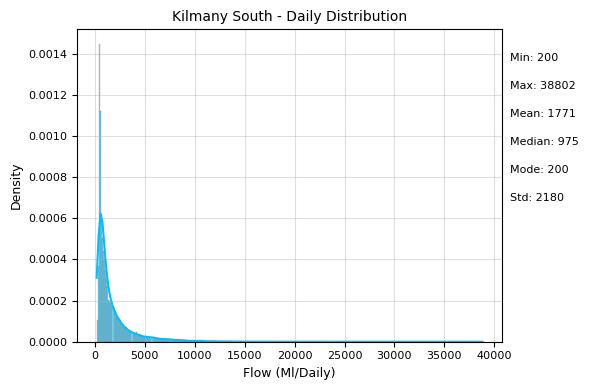

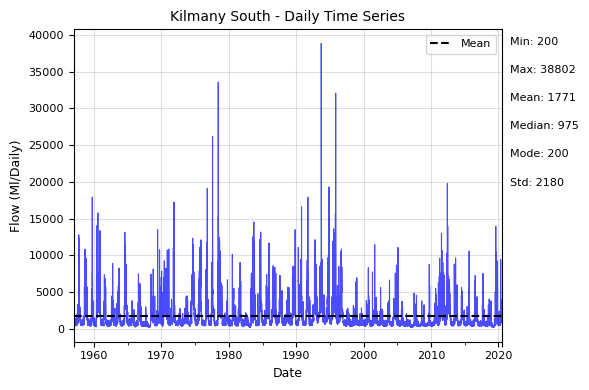

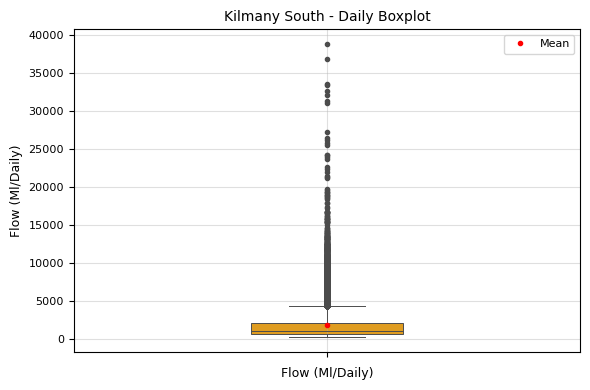

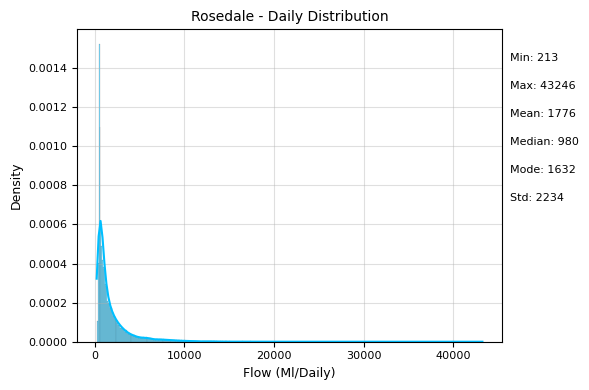

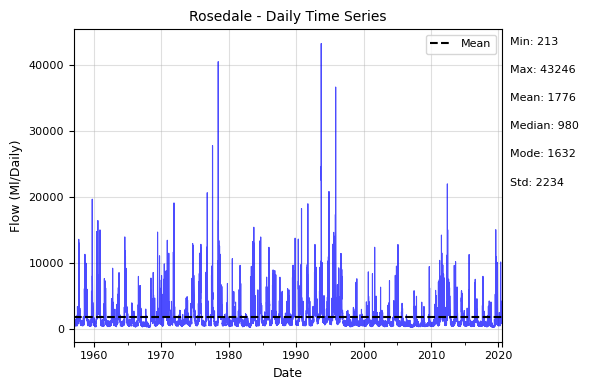

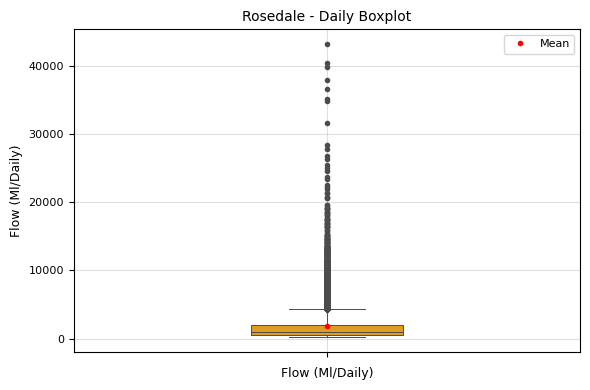

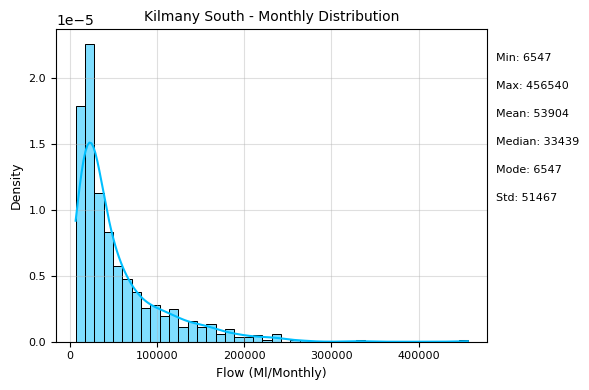

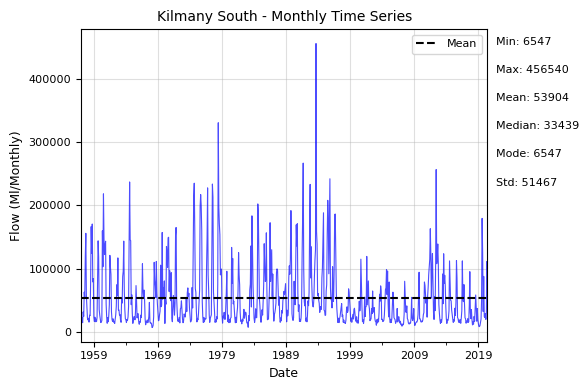

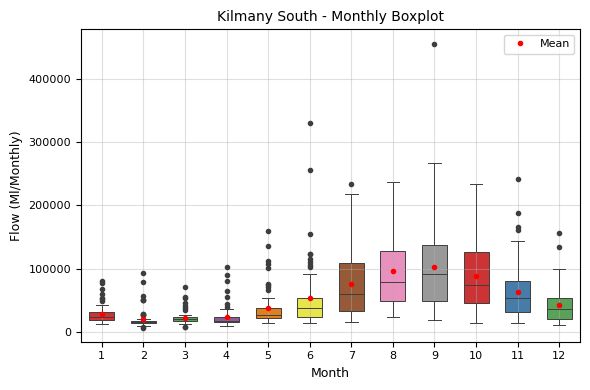

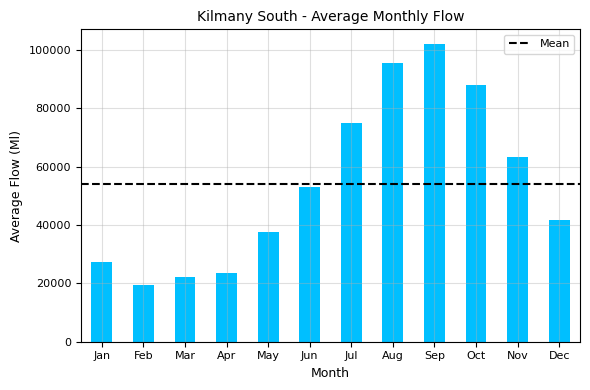

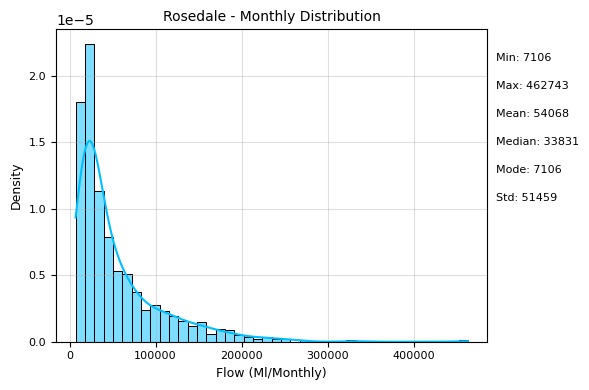

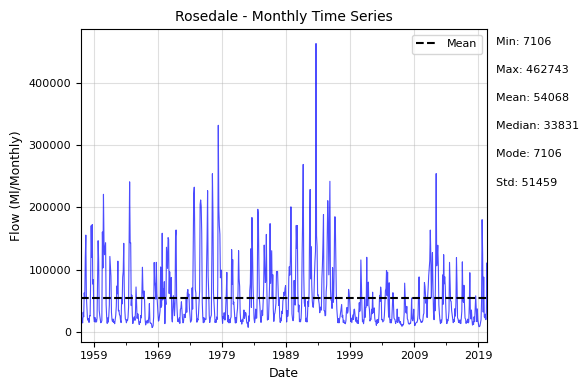

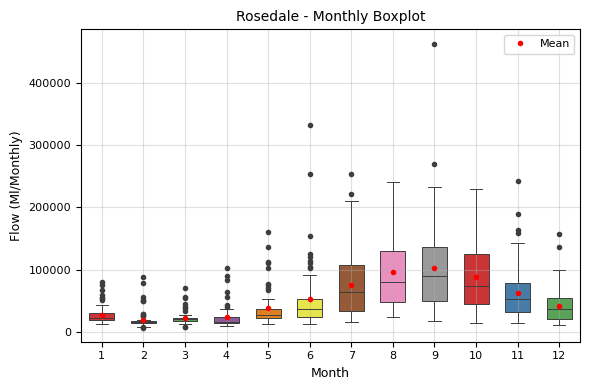

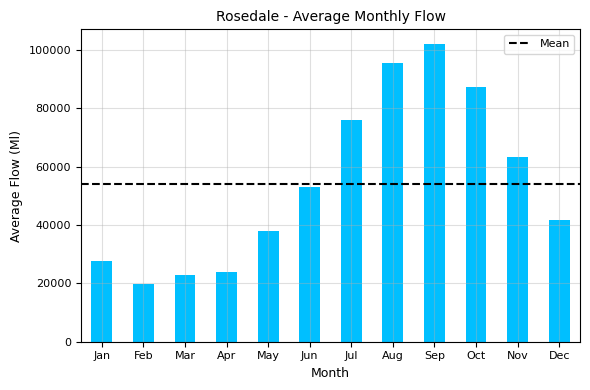

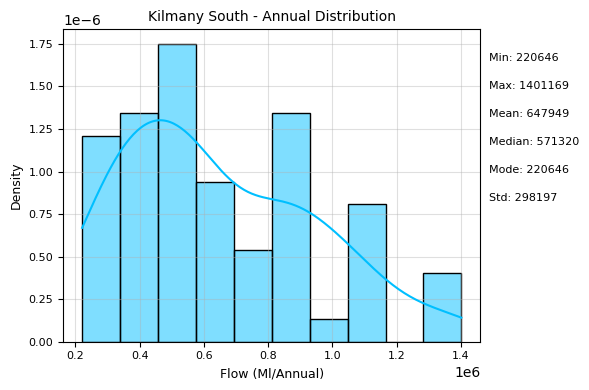

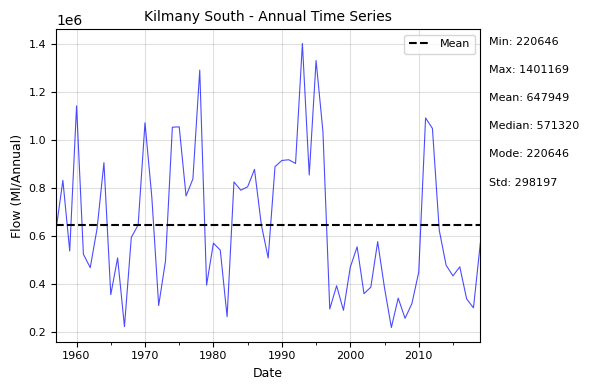

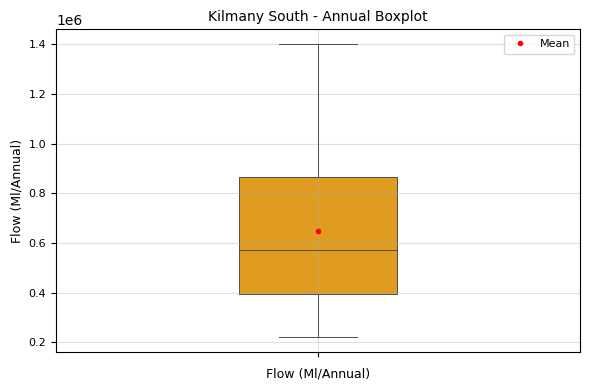

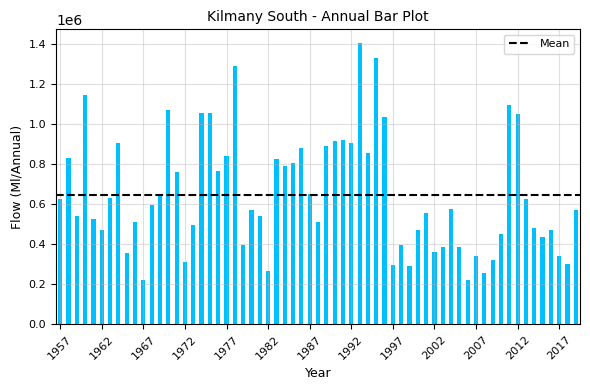

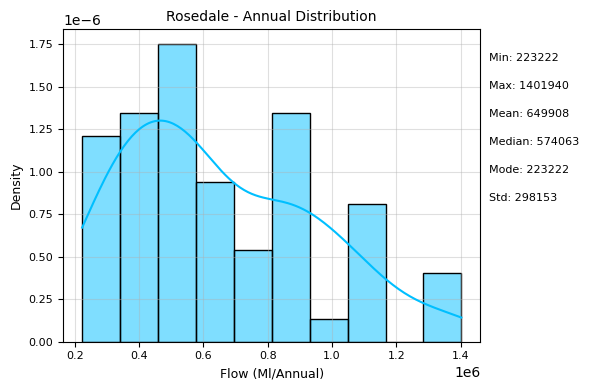

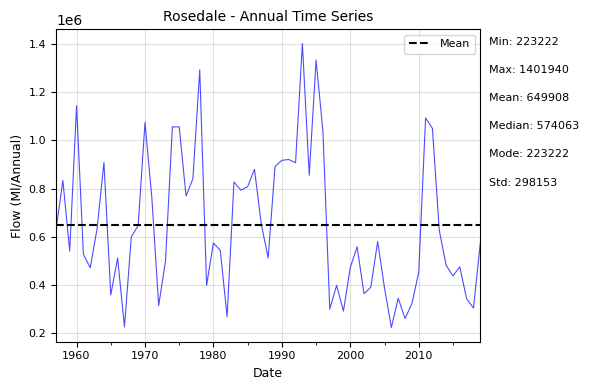

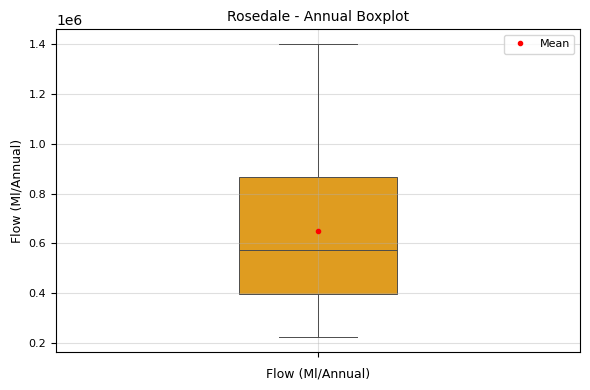

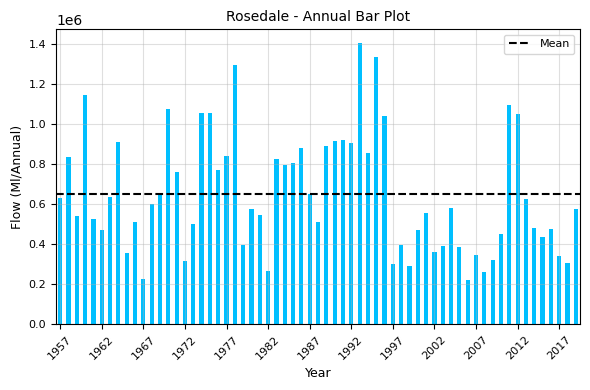

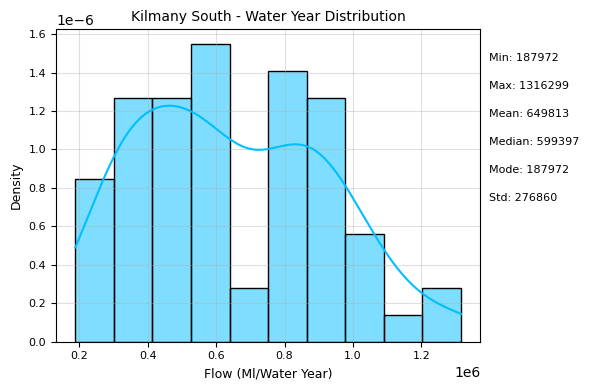

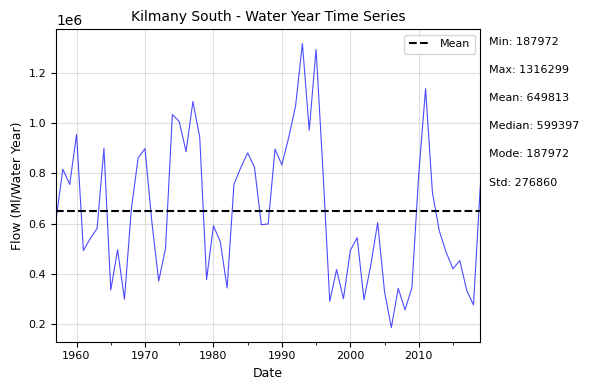

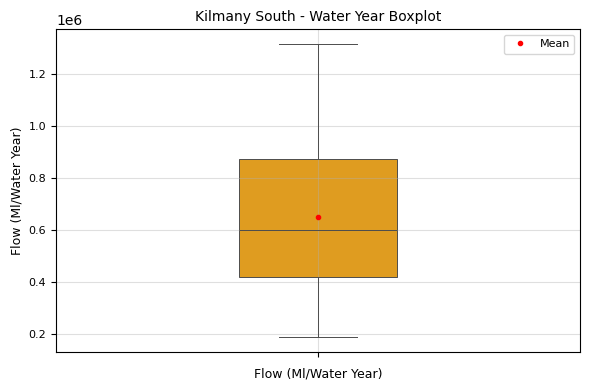

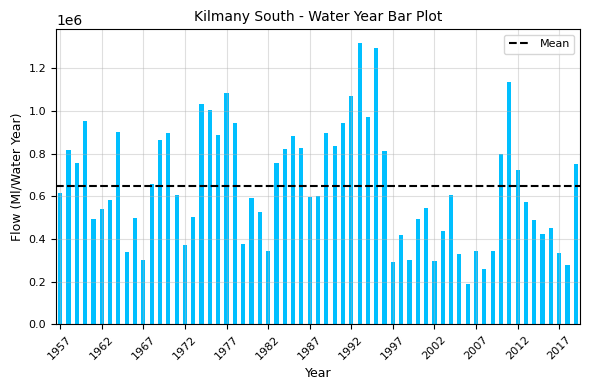

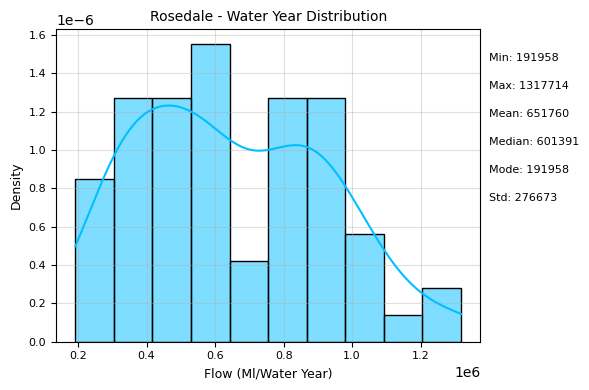

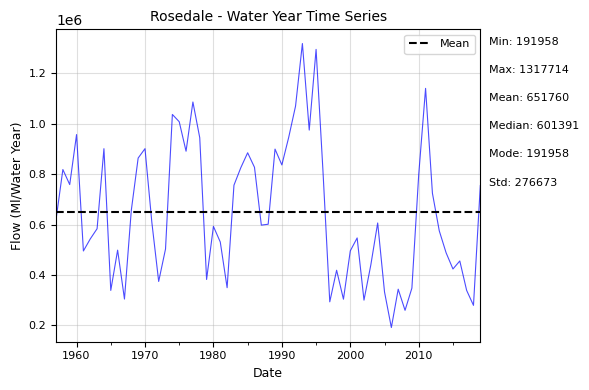

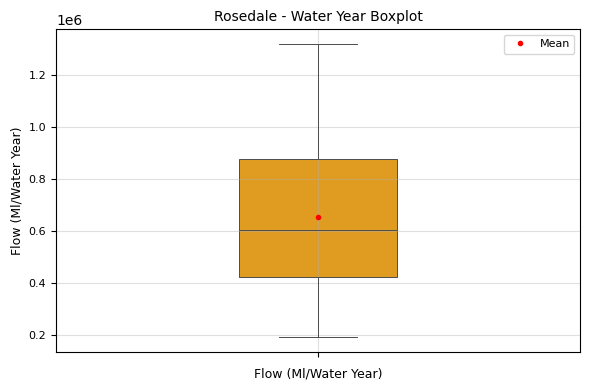

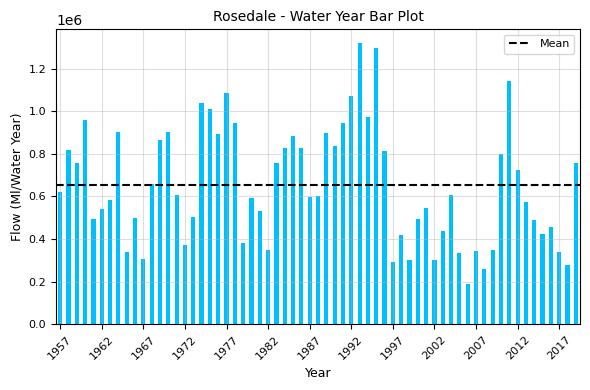

In [6]:
# Function to create and annotate the plots
def plot_distribution(data, column, aggregation, output_folder):
    plt.figure(figsize=(6, 4))
    # Set the number of bins based on the aggregation level
    if aggregation in ["Annual", "Water Year"]:
        bins = 10
    else:
        bins = 'auto'  # Let seaborn automatically determine the number of bins
    
    # Use 'density' to ensure the y-axis is normalized between 0 and 1
    sns.histplot(data[column], color='deepskyblue', kde=True, stat='density', bins=bins)
    plt.title(f"{column} - {aggregation} Distribution", fontsize=10)
    plt.xlabel(f'Flow (Ml/{aggregation})', fontsize=9)
    plt.ylabel('Density', fontsize=9)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    plt.grid(True, alpha=0.4)
    
    # Calculate annotation positions relative to plot size
    y_start = 0.9
    y_step = 0.09
    statistics = {
        'Min': round(data[column].min()),
        'Max': round(data[column].max()),
        'Mean': round(data[column].mean()),
        'Median': round(data[column].median()),
        'Mode': round(data[column].mode().values[0] if not data[column].mode().empty else np.nan),
        'Std': round(data[column].std())
    }

    for i, (stat, value) in enumerate(statistics.items()):
        plt.annotate(f'{stat}: {value}', xy=(1.02, y_start - i*y_step), xycoords='axes fraction', fontsize=8, ha='left')
    
    # Save the histogram plot
    plot_path = os.path.join(output_folder, f"Distplot-{column}-{aggregation}.png")
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()
    plt.close()  # Close the current plot to free memory

    # Create and save the line plot
    plt.figure(figsize=(6, 4))
    data[column].plot(color='blue', alpha=0.7, linewidth=0.8, label='_nolegend_')  # Suppress the line legend
    mean_value = round(data[column].mean())
    plt.axhline(mean_value, color='black', linestyle='--', label="Mean")
    plt.title(f"{column} - {aggregation} Time Series", fontsize=10)
    plt.xlabel('Date', fontsize=9)
    plt.ylabel(f'Flow (Ml/{aggregation})', fontsize=9)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    plt.grid(True, alpha=0.4)
    plt.legend(fontsize=8)

    # Add statistical summary annotations to the line plot
    y_start = 0.95
    for i, (stat, value) in enumerate(statistics.items()):
        plt.annotate(f'{stat}: {value}', xy=(1.02, y_start - i*y_step), xycoords='axes fraction', fontsize=8, ha='left')

    # Save the line plot
    line_plot_path = os.path.join(output_folder, f"Lineplot-{column}-{aggregation}.png")
    plt.tight_layout()
    plt.savefig(line_plot_path)
    plt.show()
    plt.close()  # Close the current plot to free memory

    # Create and save the box plot with specified modifications
    plt.figure(figsize=(6, 4))  # Same figure size as histogram and line plot
    flierprops = dict(marker='o', color='red', markersize=3)  # Smaller outlier markers
    if aggregation == "Monthly":
        # Create 12 box plots for each month
        data['Month'] = data.index.month
        sns.boxplot(x='Month', y=column, data=data, showmeans=True, palette="Set1", linewidth=0.7, width=0.6,
                    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red", "markersize": 3},
                    flierprops=flierprops)
        plt.title(f"{column} - Monthly Boxplot", fontsize=10)
        plt.xlabel('Month', fontsize=9)
    else:
        sns.boxplot(y=data[column], showmeans=True, color="orange", linewidth=0.7, width=0.3,  # Thinner boxes for daily, annual, and water year
                    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red", "markersize": 3},
                    flierprops=flierprops)
        plt.title(f"{column} - {aggregation} Boxplot", fontsize=10)
        plt.xlabel(f'Flow (Ml/{aggregation})', fontsize=9)
    
    plt.ylabel(f'Flow (Ml/{aggregation})', fontsize=9)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    plt.grid(True, alpha=0.4)
    
    # Add legend to show only the mean
    plt.legend([plt.Line2D([0], [0], color="w", marker="o", markerfacecolor="red", markeredgecolor="red", markersize=3)],
               ["Mean"], loc='upper right', fontsize=8)

    # Save the box plot
    box_plot_path = os.path.join(output_folder, f"Boxplot-{column}-{aggregation}.png")
    plt.tight_layout()
    plt.savefig(box_plot_path)
    plt.show()
    plt.close()  # Close the current plot to free memory

    # Create and save the bar plot for annual or water year data
    if aggregation in ["Annual", "Water Year"]:
        plt.figure(figsize=(6, 4))
        data_annual = data[column].resample('Y').mean()
        data_annual.plot(kind='bar', color='deepskyblue', label='_nolegend_')
        mean_value = round(data_annual.mean())
        plt.axhline(mean_value, color='black', linestyle='--', label="Mean")
        plt.title(f"{column} - {aggregation} Bar Plot", fontsize=10)
        plt.xlabel('Year', fontsize=9)
        plt.ylabel(f'Flow (Ml/{aggregation})', fontsize=9)
        plt.xticks(rotation=45)
        plt.xticks(ticks=np.arange(0, len(data_annual), step=5), labels=data_annual.index.year[::5], fontsize=8)
        plt.tick_params(axis='y', labelsize=8)
        plt.grid(True, alpha=0.4)
        plt.legend(fontsize=8)
        bar_plot_path = os.path.join(output_folder, f"Barplot-{column}-{aggregation}.png")
        plt.tight_layout()
        plt.savefig(bar_plot_path)
        plt.show()
        plt.close()

    # Create and save the bar plot for monthly data averaged over years
    if aggregation == "Monthly":
        plt.figure(figsize=(6, 4))
        data['Year'] = data.index.year
        monthly_avg = data.groupby('Month')[column].mean()
        monthly_avg.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        monthly_avg.plot(kind='bar', color='deepskyblue', label='_nolegend_')
        mean_value = round(monthly_avg.mean())
        plt.axhline(mean_value, color='black', linestyle='--', label="Mean")
        plt.title(f"{column} - Average Monthly Flow", fontsize=10)
        plt.xlabel('Month', fontsize=9)
        plt.ylabel(f'Average Flow (Ml)', fontsize=9)
        plt.xticks(rotation=0, fontsize=8)
        plt.tick_params(axis='y', labelsize=8)
        plt.grid(True, alpha=0.4)
        plt.legend(fontsize=8)
        avg_monthly_plot_path = os.path.join(output_folder, f"Barplot-{column}-AvgMonthly.png")
        plt.tight_layout()
        plt.savefig(avg_monthly_plot_path)
        plt.show()
        plt.close()

# Function to calculate summary statistics and plot distribution for each column in the dictionaries
def process_aggregated_data(combined_dict, output_folder):
    for aggregation, data_dict in combined_dict.items():
        for column, df in data_dict.items():
            # Determine the subfolder for each column within the aggregation
            subfolder_path = os.path.join(output_folder, column)
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)
            """
            # Save summary statistics as csv file
            summary_stats = df.describe().T
            summary_path = os.path.join(subfolder_path, f"Summary-{aggregation}.csv")
            summary_stats.to_csv(summary_path)
            """
            # Plot and save the distribution, line plot, and box plot
            plot_distribution(df, column, aggregation, subfolder_path)

# Example dictionaries holding aggregated data (Daily, Monthly, Annual, Water Year)
# These would be created during the aggregation process described in previous code examples.
combined_dict = {
    "Daily": Daily_dict,
    "Monthly": Monthly_dict,
    "Annual": Annual_dict,
    "Water Year": Water_year_dict
}
# Process the data in the dictionaries and save the outputs
process_aggregated_data(combined_dict, output_folder)

## Compare flow statistc for befor and after a desired date (for example before and after Basin plan or Millennium drought)

Enter the time point for comparison (e.g., '2000-01-01'):  2000-01-01


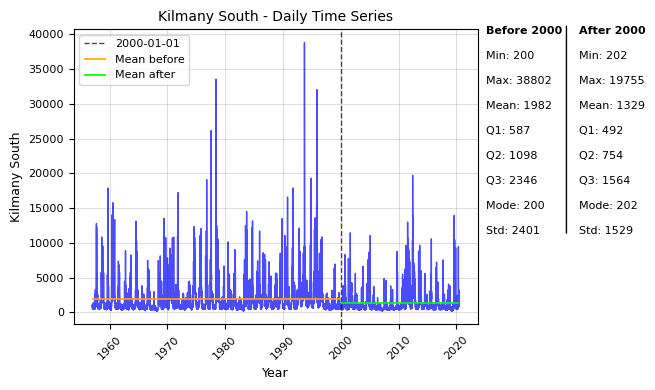

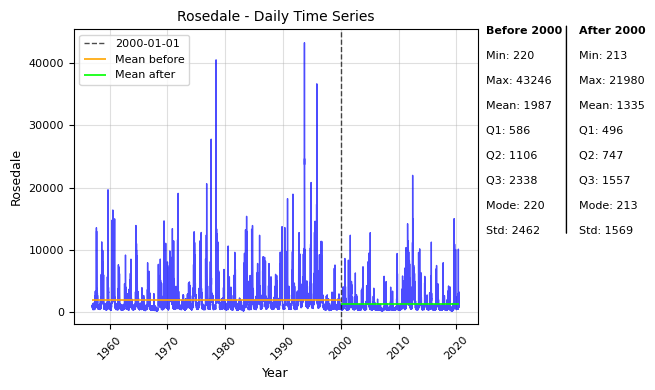

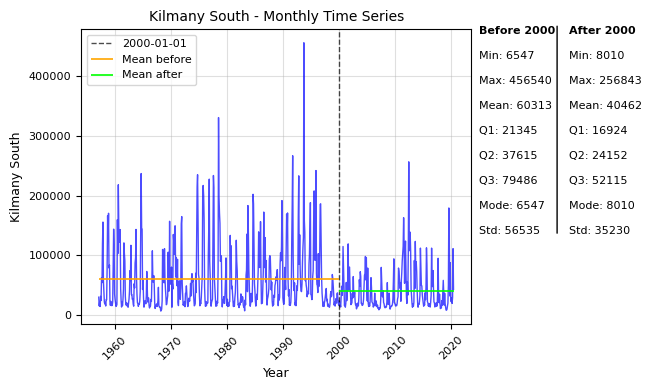

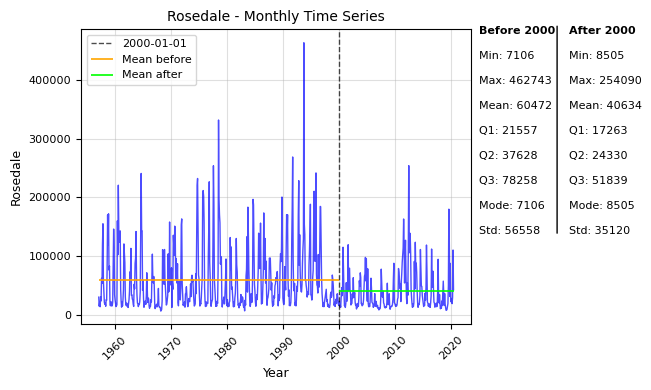

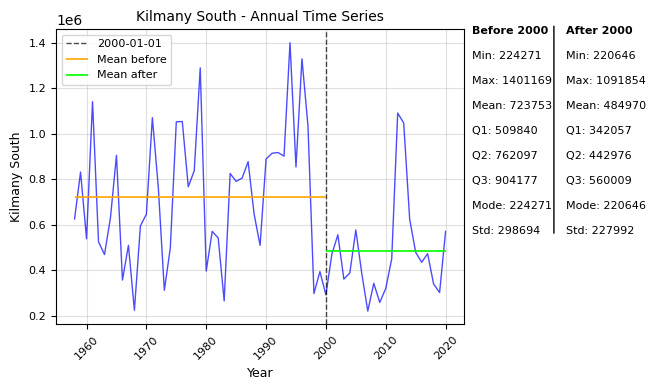

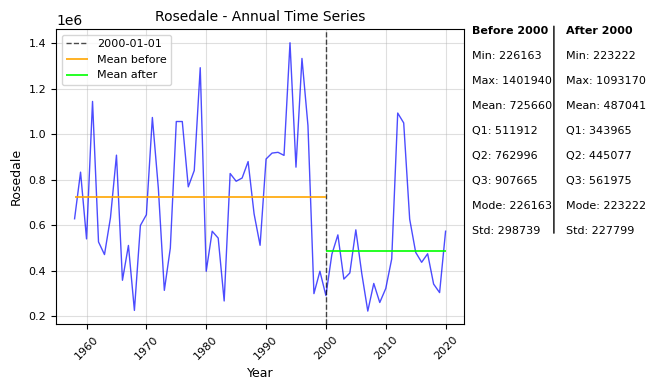

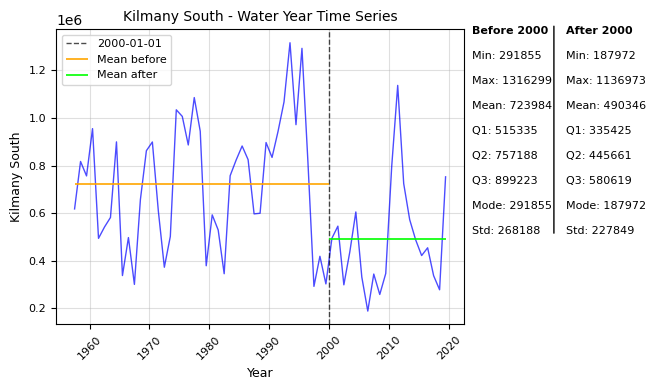

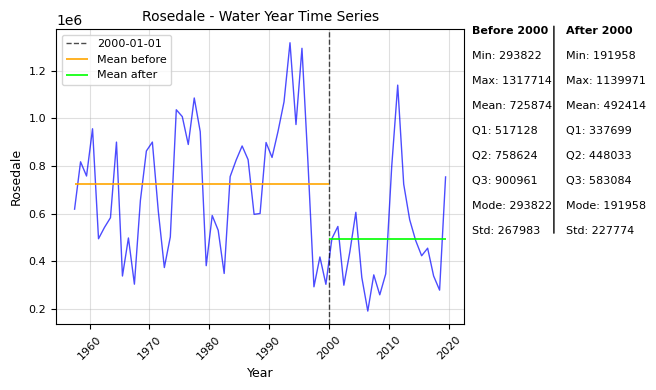

In [7]:
# Function to create and annotate the line plot and save comparison data
def plot_line(data, column, aggregation, time_point, subfolder_path):
    plt.figure(figsize=(7, 4))
    
    # Create a line plot with smaller markers
    sns.lineplot(x=data.index, y=data[column], color='blue', alpha=0.7, linewidth=1)
    plt.axvline(pd.Timestamp(time_point), color='black', alpha=0.7, linestyle='--', linewidth=1, label=time_point)
    plt.title(f'{column} - {aggregation} Time Series', fontsize=10)
    plt.xlabel('Year', fontsize=9)
    plt.ylabel(f'{column}', fontsize=9)
    plt.tick_params(axis='x', labelsize=8, rotation=45)
    plt.tick_params(axis='y', labelsize=8)
    plt.grid(True, alpha=0.4)
    
    # Split data into before and after the specified time point
    data_before = data[data.index < pd.Timestamp(time_point)].copy()
    data_after = data[data.index >= pd.Timestamp(time_point)].copy()
    
    # Add a label column to indicate "before" or "after"
    data_before['Period'] = 'Before'
    data_after['Period'] = 'After'
    
    # Combine the before and after data
    combined_data = pd.concat([data_before, data_after])
    
    # Save the combined comparison data as a single CSV file
    combined_csv_path = os.path.join(subfolder_path, f"{column}-Comparison-{aggregation}.csv")
    combined_data.to_csv(combined_csv_path)
    
    # Calculate statistics
    statistics_before = {
        'Min': data_before[column].min(),
        'Max': data_before[column].max(),
        'Mean': data_before[column].mean(),
        'Q1': data_before[column].quantile(0.25),
        'Q2': data_before[column].median(),
        'Q3': data_before[column].quantile(0.75),
        'Mode': data_before[column].mode().values[0] if not data_before[column].mode().empty else np.nan,
        'Std': data_before[column].std()
    }

    statistics_after = {
        'Min': data_after[column].min(),
        'Max': data_after[column].max(),
        'Mean': data_after[column].mean(),
        'Q1': data_after[column].quantile(0.25),
        'Q2': data_after[column].median(),
        'Q3': data_after[column].quantile(0.75),
        'Mode': data_after[column].mode().values[0] if not data_after[column].mode().empty else np.nan,
        'Std': data_after[column].std()
    }
    
    # Calculate annotation positions relative to plot size
    y_start = 0.9
    y_step = 0.085  # Adjust this step size as needed

    # Annotate headers
    plt.annotate(f'Before {time_point[:4]}', xy=(1.02, y_start + y_step), xycoords='axes fraction', fontsize=8, ha='left', fontweight='bold')
    plt.annotate(f'After {time_point[:4]}', xy=(1.25, y_start + y_step), xycoords='axes fraction', fontsize=8, ha='left', fontweight='bold')

    # Annotate statistics for before the specified time point on the left side
    for i, (stat, value) in enumerate(statistics_before.items()):
        plt.annotate(f'{stat}: {value:.0f}', xy=(1.02, y_start - i*y_step), xycoords='axes fraction', fontsize=8, ha='left')
    
    # Annotate statistics for after the specified time point on the right side
    for i, (stat, value) in enumerate(statistics_after.items()):
        plt.annotate(f'{stat}: {value:.0f}', xy=(1.25, y_start - i*y_step), xycoords='axes fraction', fontsize=8, ha='left')
    
    # Add a vertical line between the columns of annotations
    line_x = 1.22
    plt.annotate('', xy=(line_x, 0.3), xytext=(line_x, 1.02), xycoords='axes fraction', textcoords='axes fraction',
                 arrowprops=dict(arrowstyle='-', color='black', lw=1))

    # Add horizontal lines for the mean before and after the time point
    plt.hlines(y=statistics_before['Mean'], xmin=data_before.index.min(), xmax=pd.Timestamp(time_point), color='orange', linestyle='-', linewidth=1.2, label='Mean before')
    plt.hlines(y=statistics_after['Mean'], xmin=pd.Timestamp(time_point), xmax=data_after.index.max(), color='lime', linestyle='-', linewidth=1.2, label='Mean after')

    # Add legend and position it outside the plot
    plt.legend(loc='upper left', fontsize=8)
    plt.tight_layout()

    # Save the plot in the relevant subfolder
    plot_path = os.path.join(subfolder_path, f"{column}-Comparison-{aggregation}.png")
    plt.savefig(plot_path)
    plt.show()
    plt.close()  # Close the current plot to free memory

# Function to process each dataset in the dictionaries and create the plots
def compare_and_plot_all(combined_dict, time_point, output_folder):
    for aggregation, data_dict in combined_dict.items():
        for column, df in data_dict.items():
            # Determine the subfolder for each column within the aggregation
            subfolder_path = os.path.join(output_folder, column)
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)
            
            # Plot and save the comparison plot and combined data
            plot_line(df, column, aggregation, time_point, subfolder_path)

combined_dict = {
    "Daily": Daily_dict,
    "Monthly": Monthly_dict,
    "Annual": Annual_dict,
    "Water Year": Water_year_dict
}

# Get the time point from the user
time_point = input("Enter the time point for comparison (e.g., '2000-01-01'): ").strip()

# Process the data in the dictionaries and save the comparison plots and combined data
compare_and_plot_all(combined_dict, time_point, output_folder)


## Flood Frequency analysis

Flood data is saved in the folders


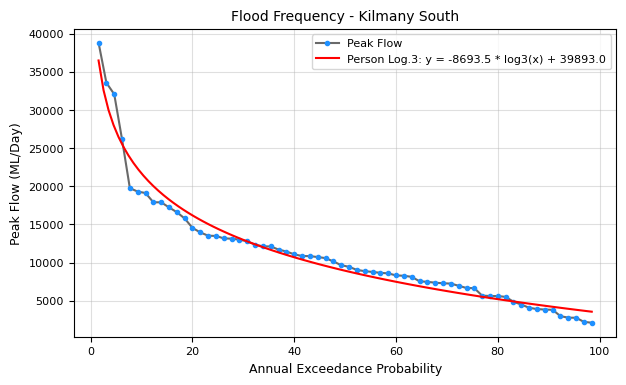

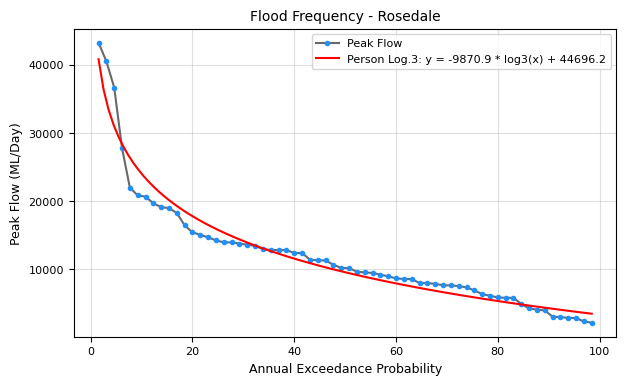

In [15]:
flood_dict = {}

# Iterate through each column in the Daily_dict
for col, daily_data in Daily_dict.items():
    # Ensure 'Date' is the index
    if 'Date' in daily_data.columns:
        daily_data.set_index('Date', inplace=True)
    
    # Resample to get the maximum flow for each year (yearly peak flows)
    peak_flows = daily_data.resample('Y')[col].max()
    
    # Find the corresponding years of peak flows
    years_of_peak_flows = daily_data.loc[daily_data.groupby(daily_data.index.year)[col].idxmax()].index.year
    
    # Create a DataFrame to store the results
    flood_data = pd.DataFrame({'Year': years_of_peak_flows, 'Peak Flow': peak_flows})
    flood_data.set_index('Year', inplace=True)

    # Sort the flood data by peak flow
    flood_sorted = flood_data.sort_values(by='Peak Flow', ascending=False).reset_index(drop=True)
    
    # Calculate exceedance probability and return period
    N = len(flood_sorted)
    flood_sorted['Exceedance Probability'] = ((flood_sorted.index + 1) / (N + 1)) * 100  # Exceedance probability 
    flood_sorted['Return Period'] = 100 / flood_sorted['Exceedance Probability']  # Return period
    flood_sorted = flood_sorted.round(2)
    
    # Store the results in the dictionary
    flood_dict[col] = flood_sorted

    # Determine the subfolder for each column
    subfolder_path = os.path.join(output_folder, col)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)
    
    # Save the flood data to a CSV file in the relevant subfolder
    csv_path = os.path.join(subfolder_path, f"{col}_Flood_Frequency.csv")
    flood_sorted.to_csv(csv_path, index=False)
# Completion message
print(f"Flood data is saved in the folders")
print('=======================================================================================')

# Define the logarithmic function with base 3
def log3_func(x, a, b):
    return a * np.log(x) / np.log(3) + b

# Iterate over each column to create and save the plots
for df, flood in flood_dict.items():
    # Extract data from DataFrame
    exceedance_probabilities = flood['Exceedance Probability']
    peak_flows = flood['Peak Flow']
    
    # Fit the logarithmic model to the data
    popt, pcov = curve_fit(log3_func, exceedance_probabilities, peak_flows)
    
    plt.figure(figsize=(7, 4))
    plt.plot(exceedance_probabilities, peak_flows, marker='o',
             markersize=3, linestyle='-', color='dimgray',
             markerfacecolor='dodgerblue', markeredgecolor='dodgerblue',
             label='Peak Flow')
    
    # Plot fitted line
    x_fit = np.linspace(min(exceedance_probabilities), max(exceedance_probabilities), 100)
    plt.plot(x_fit, log3_func(x_fit, *popt), 'r-',
             label=f'Person Log.3: y = {popt[0]:.1f} * log3(x) + {popt[1]:.1f}', color='red')
    
    # Customize plot labels and title
    plt.ylabel('Peak Flow (ML/Day)', fontsize=9)
    plt.xlabel('Annual Exceedance Probability', fontsize=9)
    plt.title(f'Flood Frequency - {df}', fontsize=10)
    plt.xticks(fontsize=8)  # Adjust fontsize of x ticks
    plt.yticks(fontsize=8)  # Adjust fontsize of y ticks
    plt.grid(True, alpha=0.4)
    plt.legend(fontsize=8)
    #plt.xscale('log')  # Logarithmic scale for better visualization
    #plt.yscale('log')  # Logarithmic scale for better visualization
    
    # Determine the subfolder path for saving the plot
    subfolder_path = os.path.join(output_folder, df)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)
    
    # Save the plot in the relevant subfolder
    plot_path = os.path.join(subfolder_path, f"Flood_Frequency_Exceedance_Probability_{df}.png")
    plt.savefig(plot_path)
    plt.show()
    plt.close()  # Close the current plot to free memory

### Predict the peak flow for any AEP(%)

In [13]:
# Define the logarithmic function with base 3
def log3_func(x, a, b):
    return a * np.log(x) / np.log(3) + b

# Example list of Annual Exceedance Probabilities (AEPs)
AEPs = [98.1, 86.47, 63.21, 50, 20, 10, 5, 2, 1, 0.5]

# Function to fit the model and make predictions
def predict_peak_flow(exceedance_prob, Peak_flow, station_name):
    # Fit the logarithmic model to the data
    popt1, pcov1 = curve_fit(log3_func, exceedance_prob, Peak_flow)
    
    # Predict peak flows for each AEP in the list
    predicted_flows = []
    for aep in AEPs:
        predicted_flow = round(log3_func(aep, *popt1), 1)
        predicted_flows.append(predicted_flow)
    
    # Create a DataFrame to store the initial results
    results_df = pd.DataFrame({
        'Station': [station_name] * len(AEPs),
        'AEP (%)': AEPs,
        'Predicted Peak Flow (ML/Day)': predicted_flows
    })
    
    return results_df, popt1

# Loop to process each station in the dictionary
all_results = []

# Ask for additional predictions just once
add_more = input("The code predicts flow for [98.1, 86.47, 63.21, 50, 20, 10, 5, 2, 1, 0.5] AEPs. Do you want to predict peak flow for another AEP? (yes/no): ").lower()
additional_aeps = []
if add_more == 'yes':
    input_values = input("Enter the Annual Exceedance Probabilities (AEPs) to predict peak flow (comma-separated): ")
    additional_aeps = [float(aep.strip()) for aep in input_values.split(',')]

for station_name, station_data in flood_dict.items():
    # Extract data from DataFrame
    exceedance_prob = station_data['Exceedance Probability']
    Peak_flow = station_data['Peak Flow']
    
    # Call the function to fit the model and make initial predictions for the station
    station_results, popt1 = predict_peak_flow(exceedance_prob, Peak_flow, station_name)
    
    # Add additional predictions if required
    for additional_aep in additional_aeps:
        predicted_flow = round(log3_func(additional_aep, *popt1), 1)
        new_row = pd.DataFrame({
            'Station': [station_name],
            'AEP (%)': [additional_aep],
            'Predicted Peak Flow (ML/Day)': [predicted_flow]
        })
        station_results = pd.concat([station_results, new_row], ignore_index=True)
        station_results=station_results.sort_values(by='AEP (%)')
    
    # Determine the subfolder path for saving the CSV file
    subfolder_path = os.path.join(output_folder, station_name)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)
    
    # Save the results to a CSV file in the relevant subfolder
    csv_path = os.path.join(subfolder_path, f"Predicted_Peak_Flow_{station_name}.csv")
    station_results.to_csv(csv_path, index=False)
    
    all_results.append(station_results)

# Concatenate all results into a single DataFrame (if needed)
final_results_df = pd.concat(all_results, ignore_index=True)
print('The predicted peak flows for each gaugeis saved in its folder')
final_results_df

The code predicts flow for [98.1, 86.47, 63.21, 50, 20, 10, 5, 2, 1, 0.5] AEPs. Do you want to predict peak flow for another AEP? (yes/no):  yes
Enter the Annual Exceedance Probabilities (AEPs) to predict peak flow (comma-separated):  4, 75


The predicted peak flows for each gaugeis saved in its folder


,Station,AEP (%),Predicted Peak Flow (ML/Day)
0,Kilmany South,0.5,45378.0
1,Kilmany South,1.0,39893.0
2,Kilmany South,2.0,34408.0
3,Kilmany South,4.0,28923.0
4,Kilmany South,5.0,27157.2
5,Kilmany South,10.0,21672.2
6,Kilmany South,20.0,16187.2
7,Kilmany South,50.0,8936.4
8,Kilmany South,63.21,7081.3
9,Kilmany South,75.0,5727.9


### Flow duration curve

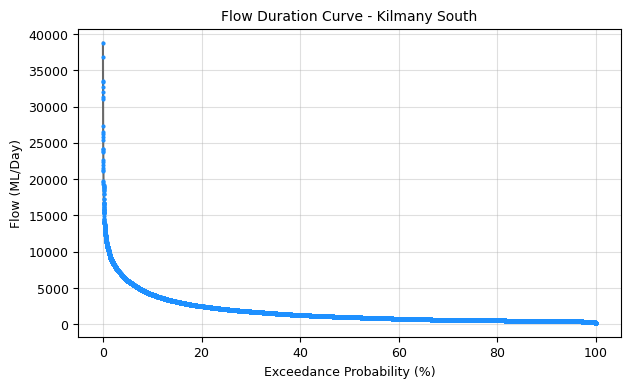

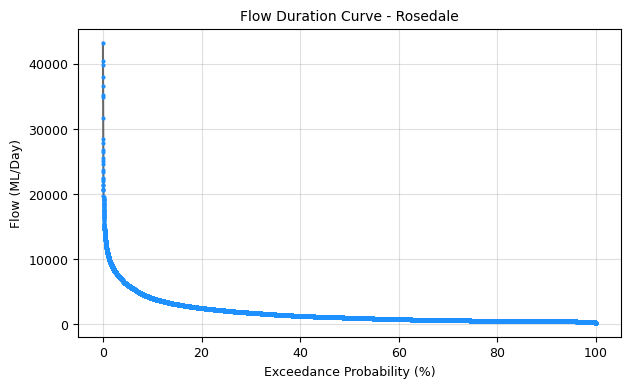

In [16]:
dfs_dict = {}
# Iterate through each column in Flow_data0 (except 'Date')
for col in Flow_data0.columns.difference(['Date']):
    # Select 'Date' and current column
    df_sorted = Flow_data0[[col]] 
    
    # Sort DataFrame by current column in descending order
    df_sorted = df_sorted.sort_values(by=col, ascending=False).reset_index(drop=True)
    
    # Calculate exceedance probability
    N = len(df_sorted)
    df_sorted['Exceedance Probability'] = ((df_sorted.index + 1) / (N + 1)) * 100
    
    # Round values for clarity (optional)
    df_sorted = df_sorted.round(2)
    
    # Rename the first column to 'Flow (ML/Day)'
    df_sorted = df_sorted.rename(columns={col: 'Flow (ML/Day)'})
    
    # Store in dictionary
    dfs_dict[col] = df_sorted
    subfolder_path = os.path.join(output_folder, col)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)
    # Save the sorted DataFrame as a CSV file in the relevant subfolder
    csv_path = os.path.join(subfolder_path, f"Flow_Duration_{col}.csv")
    df_sorted.to_csv(csv_path, index=False)
    # Plotting the flow duration curve
    plt.figure(figsize=(7, 4))
    plt.plot(df_sorted['Exceedance Probability'], df_sorted['Flow (ML/Day)'], marker='o', linestyle='-', markersize=2,
             color='dimgray', markerfacecolor='dodgerblue', markeredgecolor='dodgerblue')
    
    # Customize the plot
    plt.title(f'Flow Duration Curve - {col}', fontsize=10)
    plt.xlabel('Exceedance Probability (%)', fontsize=9)
    plt.ylabel('Flow (ML/Day)', fontsize=9)
    plt.grid(True, alpha=0.4)
    plt.xticks(fontsize=9)  # Adjust fontsize of x ticks
    plt.yticks(fontsize=9)  # Adjust fontsize of y ticks
    #plt.xscale('log')  # Logarithmic scale for better visualization
    #plt.yscale('log')  # Logarithmic scale for better visualization
    # Determine the subfolder path for saving the plot
    
    # Save the plot in the relevant subfolder
    plot_path = os.path.join(subfolder_path, f"Flow_Duration_Curve_{col}.png")
    plt.savefig(plot_path)
    plt.show()
    plt.close()  # Close the plot to free memory

## Spell analysis 

Calculate frequency and the probability of baseflow, over bank, fresh flow, and bank full

![Image Title](Flows.jpg)

Overbank: Water flows out of the river and 
across floodplain

Bankfull: Flows to inundate benches

Large Fresh: Flows cover benches in 
the river channe

Small Fresh: 

Baseflow: Water is confined to the deeper
parts of the river, keeping pool 
connect

Cease to flow: With very little flow, the river 
becomes a set of isolated poolsedls

## Calculate spell analysis and probability of n events

In [17]:
# Example data for metrics
metrics = ['Baseflow', 'Fresh flow', 'Bank full', 'Overbank']

columns_to_process = Flow_data.columns.difference(['Date'])  # Exclude the Date column
station_data = {}

# Whole analysis
for column in columns_to_process:
    station_df = {}
    # Ask for user input for multiple thresholds
    thresholds_input = input(f"For {column} enter the threshold values for 'Baseflow', 'Fresh flow', 'Bank full', 'Overbank'. Put in order and separated by commas: ")
    thresholds = [int(th) for th in thresholds_input.split(',')]
    
    for meter, threshold in zip(metrics, thresholds):
        df = Flow_data[['Date', column]].copy()
        
        df['Year'] = df['Date'].dt.year
        df['Metrics'] = meter
        df['Threshold'] = threshold
        df['Occurrence'] = df[column].apply(lambda x: 1 if x > threshold else 0)
        station_df[meter]=df  # Store the metric and corresponding dataframe
    
    # Determine the subfolder path for saving the Excel file
    subfolder_path = os.path.join(output_folder, column)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

    # Create an Excel file with multiple sheets, one for each metric
    final_file = os.path.join(subfolder_path, f"Spell binary data {column}.xlsx")
    with pd.ExcelWriter(final_file) as writer:
        for meter, df in station_df.items():
            df.to_excel(writer, sheet_name=meter, index=False)
    
    # Save the station data to the dictionary
    station_data[column] = station_df

print("Spell binary data for each gauge and metrics has been saved in an excell for in its folder.")
print('==========================================================================================================')
print(f'\nAs an example, this is data for {meter} in {column}')
df

For Kilmany South enter the threshold values for 'Baseflow', 'Fresh flow', 'Bank full', 'Overbank'. Put in order and separated by commas:  1200, 1300, 1500, 1700
For Rosedale enter the threshold values for 'Baseflow', 'Fresh flow', 'Bank full', 'Overbank'. Put in order and separated by commas:  1200, 1400,1500, 1600


Spell binary data for each gauge and metrics has been saved in an excell for in its folder.

As an example, this is data for Overbank in Rosedale


,Date,Rosedale,Year,Metrics,Threshold,Occurrence
0,1957-01-01,756.1356174,1957,Overbank,1600,0
1,1957-01-02,1103.561699,1957,Overbank,1600,0
2,1957-01-03,1175.58912,1957,Overbank,1600,0
3,1957-01-04,1158.641431,1957,Overbank,1600,0
4,1957-01-05,1104.873966,1957,Overbank,1600,0
...,...,...,...,...,...,...
23187,2020-06-26,2869.1162,2020,Overbank,1600,1
23188,2020-06-27,2330.464145,2020,Overbank,1600,1
23189,2020-06-28,1903.241223,2020,Overbank,1600,1
23190,2020-06-29,1603.945519,2020,Overbank,1600,1


In [18]:
Events = {}

for station, metrics_dict in station_data.items():
    station_df1 = {}
    for metric, df in metrics_dict.items():
        start_dates = []
        end_dates = []
        durations = []
        gap_to_next_event = []
        gap_to_same_or_greater_event = []
        
        i = 0
        while i < len(df):
            if df['Occurrence'][i] == 1:
                start_date = df['Date'][i]
                duration = 0
                
                # Track the duration of continuous 1s
                while i < len(df) and df['Occurrence'][i] == 1:
                    duration += 1
                    i += 1
                
                end_date = df['Date'][i - 1]
                
                start_dates.append(start_date)
                end_dates.append(end_date)
                durations.append(duration)
                
                # Calculate the gap to the next event
                if i < len(df) and df['Occurrence'][i] == 0:
                    gap_start = i
                    while i < len(df) and df['Occurrence'][i] == 0:
                        i += 1
                    gap_to_next_event.append((df['Date'][i] - df['Date'][gap_start]).days if i < len(df) else None)
                else:
                    gap_to_next_event.append(None)
                
                # Calculate the gap to the next same or greater duration event
                j = i
                found_same_or_greater = False
                while j < len(df):
                    if df['Occurrence'][j] == 1:
                        potential_start = j
                        potential_duration = 0
                        while j < len(df) and df['Occurrence'][j] == 1:
                            potential_duration += 1
                            j += 1
                        if potential_duration >= duration:
                            gap_to_same_or_greater_event.append((df['Date'][potential_start] - end_date).days)
                            found_same_or_greater = True
                            break
                    else:
                        j += 1
                if not found_same_or_greater:
                    gap_to_same_or_greater_event.append(None)
                
            else:
                i += 1

        # Create the resulting dataframe
        result_df = pd.DataFrame({
            'Start date': start_dates,
            'End date': end_dates,
            'Metrics': [df['Metrics'].iloc[0]] * len(start_dates),  # Assuming the Metrics value is consistent
            'Threshold': [df['Threshold'].iloc[0]] * len(start_dates),  # Assuming the Threshold value is consistent
            'Duration': durations,
            'Gap timing to next event': gap_to_next_event,
            'Gap timing to next same or greater duration event': gap_to_same_or_greater_event
        })

        # Store the result dataframe in station_df1 using the metric as key
        station_df1[metric] = result_df 

    # Create a subfolder for each station in the output directory
    subfolder_path = os.path.join(output_folder, station)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

    # Create an Excel file with multiple sheets, one for each metric
    final_file = os.path.join(subfolder_path, f"Spell events {station}.xlsx")
    with pd.ExcelWriter(final_file) as writer:
        for meter1, dff in station_df1.items():
            dff.to_excel(writer, sheet_name=meter1, index=False)

    # Store the result dataframe in the Events dictionary
    Events[station] = station_df1
print("Spell events and durations for each gauge and metrics has been saved in an excell for in its folder.")
print('==========================================================================================================')
print(f'\nAs an example, this is data for {meter1} in {station}')
dff

Spell events and durations for each gauge and metrics has been saved in an excell for in its folder.

As an example, this is data for Overbank in Rosedale


,Start date,End date,Metrics,Threshold,Duration,Gap timing to next event,Gap timing to next same or greater duration event
0,1957-07-01,1957-07-03,Overbank,1600,3,7.0,8.0
1,1957-07-11,1957-07-29,Overbank,1600,19,11.0,49.0
2,1957-08-10,1957-08-18,Overbank,1600,9,4.0,29.0
3,1957-08-23,1957-08-27,Overbank,1600,5,19.0,20.0
4,1957-09-16,1957-10-31,Overbank,1600,46,5.0,258.0
...,...,...,...,...,...,...,...
469,2019-12-04,2019-12-05,Overbank,1600,2,75.0,76.0
470,2020-02-19,2020-02-22,Overbank,1600,4,66.0,67.0
471,2020-04-29,2020-05-18,Overbank,1600,20,1.0,NaN
472,2020-05-20,2020-05-30,Overbank,1600,11,23.0,NaN


In [20]:
# Function to process data for each station
def process_station_data(station_name, data_dict):
    result_list = []

    for metric_name, df in data_dict.items():
        total_events = len(df)
        unique_durations = sorted(df['Duration'].unique())

        for duration in unique_durations:
            df_filtered = df[df['Duration'] >= duration]

            frequency = len(df_filtered)
            probability = round((frequency / total_events),3)
            df_filtered1 = df[df['Duration'] == duration]
            avg_gap_timing = round(df_filtered1['Gap timing to next same or greater duration event'].mean(),0)

            result_list.append({
                "Station": station_name,  # Add the station name here
                "Metrics": metric_name,
                "Threshold": df_filtered['Threshold'].iloc[0],  # assuming threshold is constant within a metric
                "Duration": duration,
                "Frequency": frequency,
                "Probability": probability,
                "Average gap timing": avg_gap_timing
            })

    result_df = pd.DataFrame(result_list)
    return result_df
eves=[]
# Example usage with the Events dictionary
for station_name, station_data in Events.items():
    station_result1 = process_station_data(station_name, station_data)
    eves.append(station_result1)
    subfolder_path = os.path.join(output_folder, station_name)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

    # Create an Excel file with multiple sheets, one for each metric
    final_file = os.path.join(subfolder_path, f"Spell events summary {station_name}.xlsx")
    station_result1.to_csv(final_file, index=False)
station_result1

,Station,Metrics,Threshold,Duration,Frequency,Probability,Average gap timing
0,Rosedale,Baseflow,1200,1,535,1.0,41.0
1,Rosedale,Baseflow,1200,2,488,0.912,48.0
2,Rosedale,Baseflow,1200,3,429,0.802,39.0
3,Rosedale,Baseflow,1200,4,364,0.68,36.0
4,Rosedale,Baseflow,1200,5,317,0.593,53.0
...,...,...,...,...,...,...,...
296,Rosedale,Overbank,1600,159,5,0.011,3427.0
297,Rosedale,Overbank,1600,168,4,0.008,8263.0
298,Rosedale,Overbank,1600,171,3,0.006,NaN
299,Rosedale,Overbank,1600,188,2,0.004,542.0


### Getting quarry for probaibility of n events and getting quarry about avarage gap time between two events 

In [21]:
print("Gauges:")
for gauge in Events.keys():
    print(f"Gauge: {gauge}")
print("\nMetrics:")
first_gauge = next(iter(Events))
for metric in Events[first_gauge].keys():
    print(f"  Metric: {metric}")

# Step 2: Input function to ask user for specific gauge and metric
gauge_choice = input("Enter the Gauge name: ")
metric_choice = input("Enter the Metric name: ")

# Step 3: Retrieve and print the chosen data
if gauge_choice in Events and metric_choice in Events[gauge_choice]:
    result = Events[gauge_choice][metric_choice]
    # Function to calculate probability and average gap time
    def calculate_stats(min_duration, df):
        # Filter events with duration greater than or equal to min_duration
        filtered_df = df[df['Duration'] >= min_duration]
        # Total number of events
        total_events = len(df)
        # Number of events with duration greater than or equal to min_duration
        matching_events = len(filtered_df)
        # Probability calculation
        probability = matching_events / total_events
        # Average gap timing to next same or greater duration event
        filtered_df1 = df[df['Duration'] == min_duration]
        average_gap_time = filtered_df['Gap timing to next event'].mean()
        return probability, average_gap_time

    # Function to take user input and calculate probability and average gap time
    def stats_query(df):
        min_duration = int(input("Enter the minimum duration of the event: "))
        probability, average_gap_time = calculate_stats(min_duration, df)
        print(f"\nThe probability of events with duration equal or greater than {min_duration} is {probability:.3f}")
        print(f"The average gap time to the next same or greater duration event is {average_gap_time:.0f} days")
    # Example usage of the stats_query function
    stats_query(result)

else:
    print("Invalid Gauge or Metric name. Please check the available options and try again.")

Gauges:
Gauge: Kilmany South
Gauge: Rosedale

Metrics:
  Metric: Baseflow
  Metric: Fresh flow
  Metric: Bank full
  Metric: Overbank


Enter the Gauge name:  Kilmany South
Enter the Metric name:  Overbank
Enter the minimum duration of the event:  5



The probability of events with duration equal or greater than 5 is 0.6644
The average gap time to the next same or greater duration event is 33.75 days


### End of flow metrics

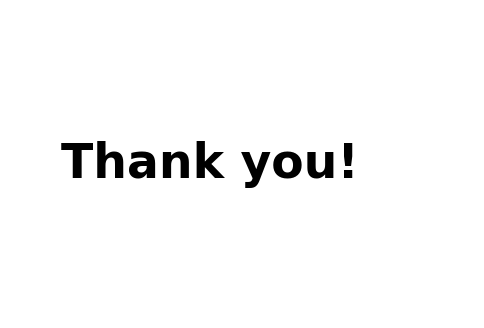

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))  # Adjusting figure size for better centering
ax.axis('off')
plt.text(0.75, 0.50, 'Thank you!', fontsize=34, fontweight='bold', color='black',
         ha='right', va='center', transform=ax.transAxes)
plt.show()